In [1]:
import functools
import glob
import os

In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import h5py
from scipy import stats

In [3]:
import lib

In [4]:
def watermark(
    fig,
    text="preliminary",
):
    fig_width, fig_height = fig.get_size_inches()
    angle = np.degrees(np.arctan2(fig_height, fig_width))
    size = np.hypot(fig_width, fig_height) * 6 
    fig.text(
        0.5,
        0.5,
        text,
        color="k",
        alpha=0.1,
        fontsize=size,
        rotation=angle,
        horizontalalignment="center",
        verticalalignment="center",
    )

    return None

In [5]:
os.environ["IMSIM_DATA"] = "/global/cfs/cdirs/desbalro"

In [6]:
shear_step_plus = 'g1_slice=0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'
shear_step_minus = 'g1_slice=-0.02__g2_slice=0.00__g1_other=0.00__g2_other=0.00__zlow=0.0__zhigh=6.0'

In [7]:
shear_step = shear_step_minus

In [8]:
# hf_imsim = h5py.File(lib.const.IMSIM_CATALOGS[shear_step])
# hf_redshift = h5py.File(lib.const.REDSHIFT_CATALOGS[shear_step])
# hf_match = h5py.File(lib.const.MATCH_CATALOGS[shear_step])

In [9]:
imsim_base = "/global/cfs/cdirs/des/y6-image-sims/fiducial-400/"
imsim_catalogs = {
    shear_step: os.path.join(
        imsim_base,
        shear_step,
        "metadetect_cutsv6_all.h5",
    )
    for shear_step in lib.const.SHEAR_STEPS
}

redshift_base = "/global/cfs/cdirs/des/y6-redshift/imsim_400Tile/fidbin_S005/"
redshift_catalogs = {
    shear_step: os.path.join(
        redshift_base,
        f"{shear_step}_sompz_unblind_fidbin.h5"
    )
    for shear_step in lib.const.SHEAR_STEPS
}

In [10]:
hf_imsim = h5py.File(imsim_catalogs[shear_step])
hf_redshift = h5py.File(redshift_catalogs[shear_step])
# hf_match = h5py.File(lib.const.MATCH_CATALOGS[shear_step])

In [11]:
zbinsc = hf_redshift["sompz"]["pzdata_weighted_S005"]["zbinsc"][:]

zc = np.concatenate([[0.0], zbinsc])

nz_sompz = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _nz_p = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_p = np.concatenate([[0.0], _nz_p])
    
    _nz_p = _nz_p / np.asarray(lib.util.sompz_integral(_nz_p, zc, 0, 6.0))
    
    
    _nz_m = hf_redshift["sompz"]["pzdata_weighted_S005"][f"bin{tomographic_bin}"][:]
    _nz_m = np.concatenate([[0.0], _nz_m])
    
    _nz_m = _nz_m / np.asarray(lib.util.sompz_integral(_nz_m, zc, 0, 6.0))

    
    nz_sompz[tomographic_bin] = (_nz_p + _nz_m) / 2 
    
nz_sompz[-1] = (nz_sompz[0] + nz_sompz[1] + nz_sompz[2] + nz_sompz[3]) / 4

In [12]:
bhat = lib.tomography.get_tomography(
    hf_imsim,
    hf_redshift,
    "noshear",
)

In [13]:
assignments = {
    mdet_step: lib.tomography.get_assignment(
        hf_imsim,
        hf_redshift,
        mdet_step,
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [14]:
statistical_weights = {
    mdet_step: lib.weights.get_shear_weights(
        hf_imsim["mdet"][mdet_step],
    )
    for mdet_step in lib.const.MDET_STEPS
}

In [15]:
g1 = {
    mdet_step: hf_imsim["mdet"][mdet_step]["gauss_g_1"][:]
    for mdet_step in lib.const.MDET_STEPS
}

g2 = {
    mdet_step: hf_imsim["mdet"][mdet_step]["gauss_g_2"][:]
    for mdet_step in lib.const.MDET_STEPS
}

In [16]:
_count, _, _ = stats.binned_statistic(
    assignments["noshear"],
    None,
    statistic="count",
    bins=lib.const.CELL_IDS,
)

count_grid = _count

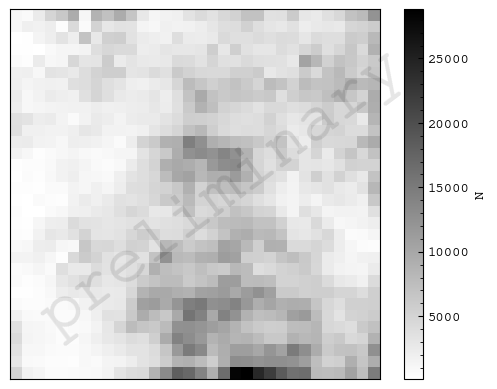

In [17]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    count_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
fig.colorbar(m, label="$N$")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

In [18]:
# response grid
mean_g_1 = {}
mean_g_2 = {}
for mdet_step in ["1p", "1m"]:
    _sum_weight, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )

    _sum_g_1, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step] * g1[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g_1[mdet_step] = _sum_g_1 / _sum_weight

    _sum_g_2, _, _ = stats.binned_statistic(
        assignments[mdet_step],
        statistical_weights[mdet_step] * g2[mdet_step],
        statistic="sum",
        bins=lib.const.CELL_IDS,
    )
    mean_g_2[mdet_step] = _sum_g_2 / _sum_weight

response_grid = (mean_g_1["1p"] - mean_g_1["1m"]) / (2 * 0.01)


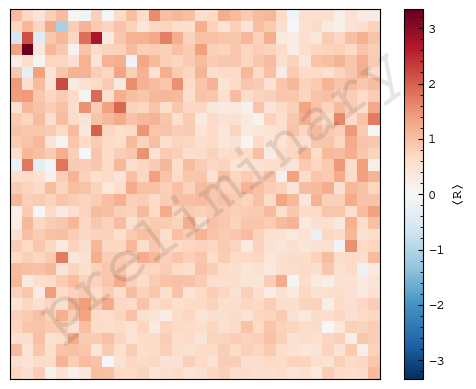

In [19]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    response_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
    norm=mpl.colors.CenteredNorm(),
    cmap="RdBu_r",
)
fig.colorbar(m, label="$〈R〉$")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

In [20]:
weight_grid, _, _ = stats.binned_statistic(
    assignments["noshear"],
    statistical_weights["noshear"],
    statistic="sum",
    bins=lib.const.CELL_IDS,
)

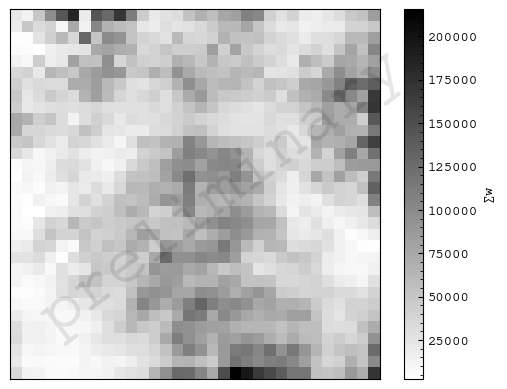

In [21]:
fig, axs = plt.subplots(1, 1)

m = axs.imshow(
    weight_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
fig.colorbar(m, label="$\\sum w$")

axs.set_xticks([])
axs.set_yticks([])

watermark(fig)

plt.show()

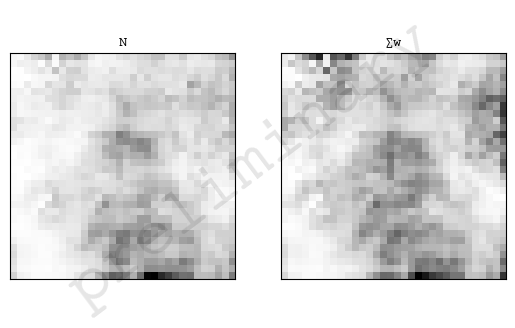

In [22]:
fig, axs = plt.subplots(1, 2)

axs[0].imshow(
    count_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
axs[0].set_title("$N$")

axs[1].imshow(
    weight_grid.reshape(lib.const.SOM_SHAPE),
    origin="lower",
)
axs[1].set_title("$\\sum w$")

for ax  in axs:
    ax.set_xticks([])
    ax.set_yticks([])

watermark(fig)

plt.show()

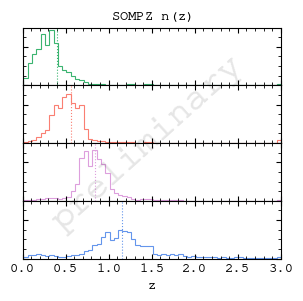

In [70]:
fig, axs = plt.subplots(len(lib.const.TOMOGRAPHIC_BINS), 1, figsize=(3 + 4/12, 3), sharex=True, sharey=True)

fig.subplots_adjust(wspace=0, hspace=0)

TOMO_COLORS = {
    0: "#3BB470",
    1: "#FA7F72",
    2: "#DD9FDD",
    3: "#6495EC",
}

for i in lib.const.TOMOGRAPHIC_BINS:
    axs[i].axvline(
        np.average(lib.const.ZVALS, weights=nz_sompz[i]),
        c=TOMO_COLORS[i],
        ls=":",
    )
    
    axs[i].stairs(
        nz_sompz[i],
        edges=lib.const.ZEDGES,
        ec=TOMO_COLORS[i],
    )

axs[-1].set_xlim(0, 3)
axs[-1].set_ylim(0, None)

axs[-1].set_xlabel("z")
axs[-1].set_yticklabels([])

axs[0].set_title("SOMPZ $n(z)$")
# fig.suptitle("SOMPZ $n(z)$")

# axs[-1].set_yscale("log")
# axs[0].legend()

watermark(fig)

fig.savefig("nz-sompz.pdf")

plt.show()

---

In [34]:
cell_assignments = {}
for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    cell_assignments[tomographic_bin] = np.unique(
        assignments["noshear"][bhat == tomographic_bin]
    ).astype(int)

assert len(
    functools.reduce(
        np.intersect1d,
        [
            cells
            for cells in cell_assignments.values()
        ],
    )
) == 0

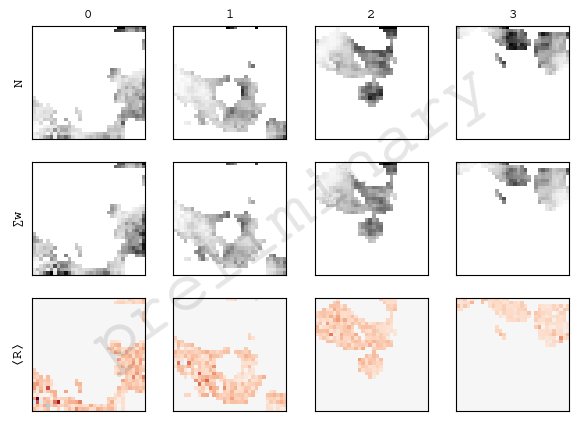

In [67]:
fig, axs = plt.subplots(
    3, len(lib.const.TOMOGRAPHIC_BINS),
    figsize=(7, 5),
    sharex=True,
    sharey=True,
)

c_norm = mpl.colors.Normalize(vmin=0)
w_norm = mpl.colors.Normalize(vmin=0)
r_norm = mpl.colors.CenteredNorm()

for tomographic_bin in lib.const.TOMOGRAPHIC_BINS:
    _c = np.zeros((len(lib.const.CELL_IDS) - 1, len(lib.const.ZEDGES) - 1))
    _w = np.zeros((len(lib.const.CELL_IDS) - 1, len(lib.const.ZEDGES) - 1))
    _r = np.zeros((len(lib.const.CELL_IDS) - 1, len(lib.const.ZEDGES) - 1))

    _c[cell_assignments[tomographic_bin]] = count_grid[cell_assignments[tomographic_bin], np.newaxis]
    _w[cell_assignments[tomographic_bin]] = weight_grid[cell_assignments[tomographic_bin], np.newaxis]
    _r[cell_assignments[tomographic_bin]] = response_grid[cell_assignments[tomographic_bin], np.newaxis]
    
    axs[0, tomographic_bin].set_title(tomographic_bin)

    axs[0, tomographic_bin].imshow(
        np.sum(_c, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=c_norm,
    )
    
    axs[1, tomographic_bin].imshow(
        np.sum(_w, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=w_norm,
    )
        
    axs[2, tomographic_bin].imshow(
        np.mean(_r, axis=1).reshape(lib.const.SOM_SHAPE),
        norm=r_norm,
        cmap="RdBu_r",
    )

axs[0, 0].set_ylabel("N")
axs[1, 0].set_ylabel("$\\sum w$")
axs[2, 0].set_ylabel("$〈R〉$")

for ax in axs.ravel():
    ax.set_xticks([])
    ax.set_yticks([])

watermark(fig)

fig.savefig("som-tomographic.pdf")
plt.show()